# MATH70121 Topics in Derivative Pricing Coursework(April 2025)

**Group Member: L.Jin, C.Fotsing and S.Wang**

# Config

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime

# Part 1 OIS Curve

## 1.1 Data

In [2]:
df = pd.read_excel("Bloomberg.xlsx", sheet_name='gbp ois results')

In [3]:
def reformat_ois_dataframe(df_raw):
    
    n = df_raw.shape[1] // 2 
    dfs = []

    for i in range(n):

        date_col = df_raw.columns[2 * i]
        rate_col = df_raw.columns[2 * i + 1]


        temp = df_raw[[date_col, rate_col]].copy()
        temp.columns = ['Date', 'Rate']

        temp['Date'] = pd.to_datetime(temp['Date'], errors='coerce')
        temp.dropna(subset=['Date'], inplace=True)

        temp.set_index('Date', inplace=True)
        temp.rename(columns={'Rate': rate_col}, inplace=True)       
        dfs.append(temp)

    df_final = pd.concat(dfs, axis=1, join='outer')
    df_final.sort_index(inplace=True)
    
    return df_final

ois_df = reformat_ois_dataframe(df)

In [4]:
ois_df.tail()

,BPSWS1Z Curncy,BPSWS2Z Curncy,BPSWSA Curncy,BPSWSB Curncy,BPSWSE Curncy,BPSWSF Curncy,BPSWSG Curncy,BPSWSH Curncy,BPSWSI Curncy,BPSWSJ Curncy,...,BPSWS8 Curncy,BPSWS9 Curncy,BPSWS10 Curncy,BPSWS12 Curncy,BPSWS15 Curncy,BPSWS20 Curncy,BPSWS25 Curncy,BPSWS30 Curncy,BPSWS40 Curncy,BPSWS50 Curncy
Date,,,,,,,,,,,,,,,,,,,,,
2024-11-20,4.702,4.704,4.70900,4.70410,4.62260,4.59625,4.56487,4.53630,4.51151,4.48554,...,3.97335,3.9790,3.99100,4.0265,4.07392,4.10692,4.09602,4.05797,3.95250,3.83579
2024-11-21,4.702,4.704,4.70675,4.70400,4.61850,4.58900,4.55400,4.52600,4.49900,4.47290,...,3.94650,3.9545,3.96800,4.0060,4.05550,4.09050,4.08150,4.04400,3.94100,3.82500
2024-11-22,4.702,4.704,4.70470,4.69700,4.59500,4.56280,4.52550,4.49250,4.46300,4.43410,...,3.89800,3.9060,3.91850,3.9560,4.00500,4.03900,4.03096,3.99400,3.88900,3.77400
2024-11-25,4.702,4.704,4.70175,4.69862,4.59495,4.55800,4.52432,4.49405,4.46341,4.43810,...,3.87000,3.8740,3.88507,3.9205,3.96757,4.00150,3.99250,3.95507,3.85157,3.73650
2024-11-26,4.702,4.704,4.70134,4.69884,4.58976,4.55437,4.52000,4.48750,4.45950,4.43272,...,3.87631,3.8813,3.89286,3.9272,3.97346,4.00550,3.99470,3.95700,3.85200,3.73500


## 1.2 Build Curves

In [5]:
from financepy.products.rates import OIS
from financepy.utils import DayCountTypes, SwapTypes, FrequencyTypes
from financepy.products.rates import OISCurve
from financepy.utils.date import Date

ois_dict = {
    "BPSWS1Z Curncy": "1W",
    "BPSWS2Z Curncy": "2W",
    "BPSWSA Curncy":  "1M",
    "BPSWSB Curncy":  "2M",
    "BPSWSC Curncy":  "3M",
    "BPSWSD Curncy":  "4M",
    "BPSWSE Curncy":  "5M",
    "BPSWSF Curncy":  "6M",
    "BPSWSG Curncy":  "7M",
    "BPSWSH Curncy":  "8M",
    "BPSWSI Curncy":  "9M",
    "BPSWSJ Curncy":  "10M",
    "BPSWSK Curncy":  "11M",
    "BPSWS1 Curncy":  "1Y",
    "BPSWS1F Curncy": "18M",
    "BPSWS2 Curncy":  "2Y",
    "BPSWS3 Curncy":  "3Y",
    "BPSWS4 Curncy":  "4Y",
    "BPSWS5 Curncy":  "5Y",
    "BPSWS6 Curncy":  "6Y",
    "BPSWS7 Curncy":  "7Y",
    "BPSWS8 Curncy":  "8Y",
    "BPSWS9 Curncy":  "9Y",
    "BPSWS10 Curncy": "10Y",
    "BPSWS12 Curncy": "12Y",
    "BPSWS15 Curncy": "15Y",
    "BPSWS20 Curncy": "20Y",
    "BPSWS25 Curncy": "25Y",
    "BPSWS30 Curncy": "30Y",
    "BPSWS40 Curncy": "40Y",
    "BPSWS50 Curncy": "50Y"
}

####################################################################
#  FINANCEPY BETA Version 0.370 - This build: 28 Oct 2024 at 20:26 #
#     This software is distributed FREE AND WITHOUT ANY WARRANTY   #
#  Report bugs as issues at https://github.com/domokane/FinancePy  #
####################################################################



In [9]:
def build_ois_curves(df):

    ois_curves = {}
    for date_str, row in df.iterrows():
       
        dt = pd.to_datetime(date_str)
        value_dt = Date(int(dt.day), int(dt.month), int(dt.year))
        ois_swaps = []

        for ticker, rate in row.items():
            tenor = ois_dict.get(ticker)
            if tenor is None or pd.isna(rate):
                continue  

            rate_decimal = rate / 100  
            inst = OIS(
                effective_dt=value_dt,
                term_dt_or_tenor=tenor,
                fixed_leg_type=SwapTypes.PAY,
                fixed_cpn=rate_decimal,
                fixed_freq_type=FrequencyTypes.QUARTERLY,
                fixed_dc_type=DayCountTypes.ACT_365F
            )
            ois_swaps.append(inst)
        
        ois_curve = OISCurve(
                    value_dt=value_dt,
                    ois_deposits=[],
                    ois_fras=[],
                    ois_swaps=ois_swaps, 
                )
        ois_curves[value_dt] = ois_curve

    return ois_curves

In [10]:
ois_curves = build_ois_curves(ois_df)

## 1.3 Plot

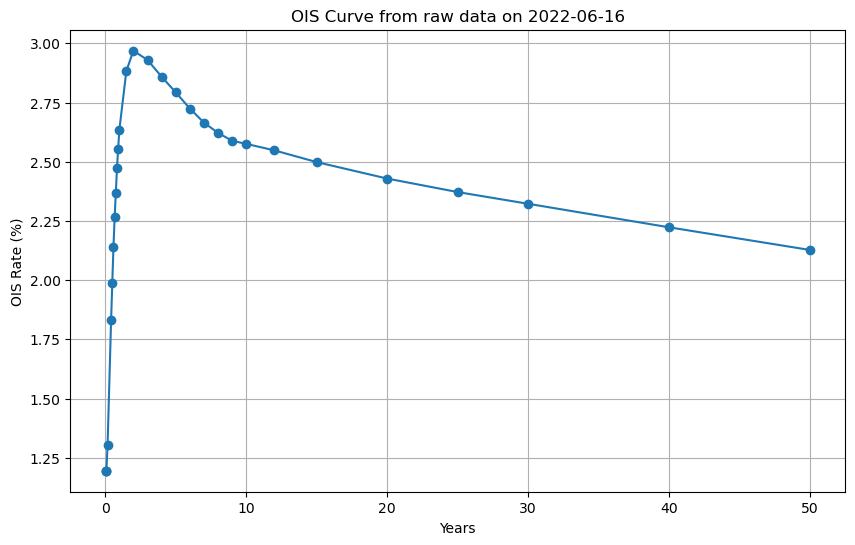

In [11]:
import matplotlib.pyplot as plt

# extract the rate row
row = ois_df.iloc[100]  # first day
date_str = ois_df.index[100]

# tenor and rate
tenors = []
rates = []

for ticker, rate in row.items():
    if pd.isna(rate):
        continue
    tenor_str = ois_dict.get(ticker)
    if tenor_str is None:
        continue
    # turn tenor into year fraction
    if "W" in tenor_str:
        years = int(tenor_str.strip("W")) / 52
    elif "M" in tenor_str:
        years = int(tenor_str.strip("M")) / 12
    elif "Y" in tenor_str:
        years = int(tenor_str.strip("Y"))
    else:
        continue  
    

    tenors.append(years)
    rates.append(rate)

# Sort
tenors, rates = zip(*sorted(zip(tenors, rates)))

# Plot
plt.figure(figsize=(10, 6))
plt.plot(tenors, rates, marker='o')
plt.title(f"OIS Curve from raw data on {date_str.strftime('%Y-%m-%d')}")
plt.xlabel("Years")
plt.ylabel("OIS Rate (%)")
plt.grid(True)
plt.savefig("ois_curve.png", dpi=300, bbox_inches='tight')
plt.show()

# Part2 Z-spread

## 2.1 Data

In [12]:
df2 = pd.read_excel("Gilts.xlsx", sheet_name='STATIC')
df3 = pd.read_excel("Gilts.xlsx", sheet_name='HIST_PRICE')

In [13]:
df2.head()

,instrument_id,bond_type_id,ticker,description,maturity_date,coupon,first_coupon_date,first_settlement_date
0,GB00B0V3WX43,GILT,UKT,UKT 4 07/09/16,2016-09-07,0.0400,2006-09-07,2006-03-02
1,GB00B3Z3K594,GILT,UKT,UKT 1.75 22/01/17,2017-01-22,0.0175,2012-01-22,2011-08-19
2,GB0008931148,GILT,UKT,UKT 8.75 25/08/17,2017-08-25,0.0875,1992-08-25,1992-04-30
3,GB00B7F9S958,GILT,UKT,UKT 1 07/09/17,2017-09-07,0.0100,2012-09-07,2012-03-08
4,GB00B1VWPC84,GILT,UKT,UKT 5 07/03/18,2018-03-07,0.0500,2007-09-07,2007-05-25


In [14]:
df3 = df3.set_index('eod_date').iloc[308:1023]
df3.head()

,GB0002404191,GB0004893086,GB0030880693,GB0032452392,GB00B00NY175,GB00B06YGN05,GB00B128DP45,GB00B16NNR78,GB00B1VWPJ53,GB00B24FF097,...,GB00BQC4R999,GB00BQC82B83,GB00BQC82C90,GB00BQC82D08,GB00BSQNRC93,GB00BSQNRD01,GB00BTHH2R79,GB00BYYMZX75,GB00BYZW3G56,GB00BZB26Y51
eod_date,,,,,,,,,,,,,,,,,,,,,
2022-01-27,1.32385,1.29010,1.12229,1.37410,1.51078,1.79839,1.59385,1.18070,1.55943,1.30151,...,NaN,NaN,NaN,NaN,NaN,NaN,1.03632,1.44296,1.02261,1.05036
2022-01-28,1.32289,1.28829,1.12183,1.37142,1.50852,1.79315,1.58915,1.18017,1.55563,1.29995,...,NaN,NaN,NaN,NaN,NaN,NaN,1.03606,1.43744,1.02242,1.04831
2022-01-31,1.31774,1.28109,1.11937,1.35949,1.49290,1.75863,1.56622,1.17592,1.53743,1.29365,...,NaN,NaN,NaN,NaN,NaN,NaN,1.03343,1.39985,1.01932,1.03727
2022-02-01,1.31695,1.28101,1.11886,1.36140,1.49566,1.76516,1.57080,1.17523,1.54073,1.29356,...,NaN,NaN,NaN,NaN,NaN,NaN,1.03294,1.40681,1.01892,1.03910
2022-02-02,1.32095,1.28700,1.12007,1.37182,1.50886,1.79733,1.59328,1.17789,1.55849,1.29875,...,NaN,NaN,NaN,NaN,NaN,NaN,1.03439,1.44202,1.02069,1.04899


## 2.2 Construct Bond Dict

In [15]:
from financepy.products.bonds import Bond

bond_dict = {}
for idx, row in df2.iterrows():
    isin = row["instrument_id"]  # ISIN, e.g. "GB00B0V3WX43"
    coupon_float = float(row["coupon"])  # e.g. 0.04 (4%)
    
    iss = pd.to_datetime(row["first_settlement_date"])
    issue_dt = Date(int(iss.day), int(iss.month), int(iss.year))
    
    
    mat_dt = pd.to_datetime(row["maturity_date"])
    maturity_dt = Date(mat_dt.day, mat_dt.month, mat_dt.year)
    
    bond_obj = Bond(issue_dt = issue_dt,
                    maturity_dt = maturity_dt,
                    coupon = coupon_float,
                    freq_type = FrequencyTypes.SEMI_ANNUAL,
                    dc_type = DayCountTypes.ACT_ACT_ICMA,
                   )
    bond_dict[isin] = bond_obj

## 2.3 Build Z-spread

In [ ]:
zspread_dict = {}

for ticker in df3.columns:
    bond = bond_dict[ticker]
    if bond is None:
        zspread_dict[ticker] = []
        continue

    z_list = []

    for date, price in df3[ticker].items():
        if np.isnan(price):
            z_list.append(None)
            continue
            
        dt = pd.to_datetime(date)
        value_dt = Date(int(dt.day), int(dt.month), int(dt.year))
     
        ois_curve = ois_curves.get(value_dt)
        if ois_curve is None:
            z_list.append(None)
            continue

        z = bond.z_spread(value_dt, price*100, ois_curve)
        z_list.append(z*100)
    
    zspread_dict[ticker] = z_list

zspread_df = pd.DataFrame(zspread_dict, index=df3.index)

In [17]:
zspread_df = pd.DataFrame(zspread_dict, index=df3.index)
zspread_df.head()

,GB00B7L9SL19,GB00BL68HG94,GB00BF0HZ991,GB00B7Z53659,GB00BMGR2791,GB00BHBFH458,GB00BLPK7110,GB0030880693,GB00BK5CVX03,GB00BTHH2R79,...,GB00BJLR0J16,GB00B06YGN05,GB00BD0XH204,GB00B54QLM75,GB00BMBL1D50,GB00BMF9LF76,GB00BYYMZX75,GB00BBJNQY21,GB00BFMCN652,GB00BLBDX619
eod_date,,,,,,,,,,,,,,,,,,,,,
2022-01-27,-0.197995,-0.131879,-0.282511,-0.256773,-0.282684,-0.310054,-0.301228,-0.294181,-0.338345,-0.314720,...,0.367329,0.337428,0.340821,0.292444,0.313249,NaN,0.297350,0.300514,0.282801,NaN
2022-01-28,-0.192501,-0.150164,-0.305314,-0.274824,-0.309850,-0.331107,-0.328188,-0.312086,-0.362225,-0.335409,...,0.350586,0.318878,0.323361,0.274525,0.295132,NaN,0.279677,0.282913,0.263670,NaN
2022-01-31,-0.150273,-0.109684,-0.287473,-0.264749,-0.298113,-0.330373,-0.322487,-0.314871,-0.353719,-0.326729,...,0.380616,0.353555,0.355010,0.308121,0.327058,NaN,0.312703,0.315592,0.294022,NaN
2022-02-01,-0.135576,-0.083690,-0.257701,-0.234906,-0.264185,-0.304171,-0.302556,-0.296116,-0.335316,-0.309339,...,0.376674,0.348382,0.352468,0.304136,0.324928,NaN,0.309208,0.311146,0.289928,NaN
2022-02-02,-0.139910,-0.122117,-0.285123,-0.258224,-0.283711,-0.320706,-0.316932,-0.311017,-0.349566,-0.326180,...,0.340425,0.309839,0.314381,0.262793,0.285439,NaN,0.271217,0.273615,0.255081,NaN


In [ ]:
zspread_df.to_csv('zspread.csv', index=True)
#zspread_df = pd.read_csv('zspread.csv', index_col=0)
#zspread_df.index = pd.to_datetime(zspread_df.index)

## 2.4 Plot

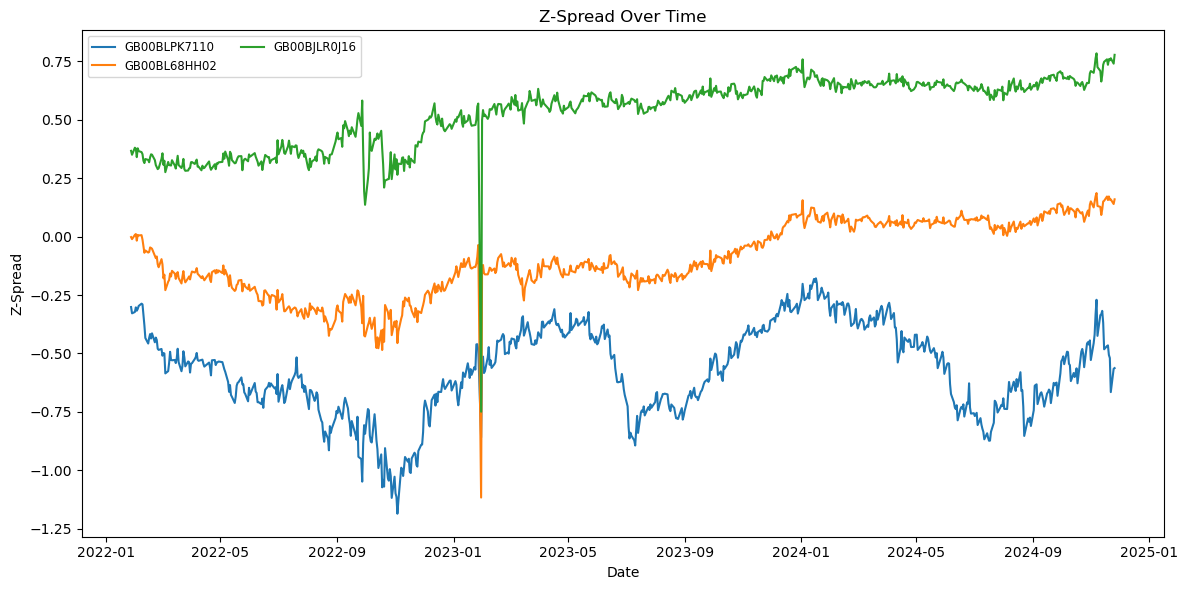

In [74]:
import matplotlib.pyplot as plt

cols = zspread_df.columns[[6, 27, 63]]

plt.figure(figsize=(12, 6))
for col in cols:
    plt.plot(zspread_df[col], label=col)
plt.title("Z-Spread Over Time")
plt.xlabel("Date")
plt.ylabel("Z-Spread")
plt.legend(loc="upper left", ncol=2, fontsize="small")
plt.tight_layout()
plt.show()

# Part 3 NSS Curve

## 3.1 Build Curve

In [18]:
maturity_dict = {}
for idx, row in df2.iterrows():
    isin = row["instrument_id"]  # "GB00B0V3WX43"
    mat_dt = pd.to_datetime(row["maturity_date"])
    maturity_dict[isin] = mat_dt

In [19]:
def nss_func(t, beta0, beta1, beta2, beta3, tau1, tau2):
    t = np.array(t)
    term1 = (1 - np.exp(-t / tau1)) / (t / tau1)
    term2 = term1 - np.exp(-t / tau1)
    term3 = (1 - np.exp(-t / tau2)) / (t / tau2) - np.exp(-t / tau2)

    term1 = np.nan_to_num(term1, nan=1.0, posinf=0.0, neginf=0.0)
    term2 = np.nan_to_num(term2, nan=0.0, posinf=0.0, neginf=0.0)
    term3 = np.nan_to_num(term3, nan=0.0, posinf=0.0, neginf=0.0)

    return beta0 + beta1 * term1 + beta2 * term2 + beta3 * term3

In [29]:
from scipy.optimize import curve_fit
import numpy as np
import pandas as pd

def get_nss_data_for_date(eod, zspread_df, maturity_dict):
    spread_series = zspread_df.loc[eod]
    t_list, z_list = [], []
    for isin, zval in spread_series.items():
        if pd.isna(zval):
            continue
        mat_dt = maturity_dict.get(isin)
        if mat_dt is None:
            continue
        t = (mat_dt - eod).days / 365.0
        if t > 0:
            t_list.append(t)
            z_list.append(zval)
    return np.array(t_list), np.array(z_list)

# set upper and lower bounds
lower_bounds = [-5, -10, -10, -10, 0.5, 1.0]
upper_bounds = [5, 10, 10, 10, 20, 50]

nss_params_dict = {}

# fit day by day
for eod in zspread_df.index:
    t_arr, z_arr = get_nss_data_for_date(eod, zspread_df, maturity_dict)

    # eliminate outliers
    valid = (z_arr > -2) & (z_arr < 4)
    t_arr, z_arr = t_arr[valid], z_arr[valid]


    if len(t_arr) < 6:
        nss_params_dict[eod] = None
        continue

    success = False
    attempts = [
        [np.mean(z_arr), 0.0, 0.0, 0.0, 2.0, 10.0],
        [np.mean(z_arr), -0.5, 0.5, 0.2, 3.0, 15.0]
    ]

    for init_guess in attempts:
        try:
            params, _ = curve_fit(
                nss_func,
                t_arr, z_arr,
                p0=init_guess,
                bounds=(lower_bounds, upper_bounds),
                maxfev=10000
            )
            nss_params_dict[eod] = params
            success = True
            break
        except:
            continue

    if not success:
        print(f"Fitting failed on {eod.date()}")
        nss_params_dict[eod] = None

# DataFrame
nss_params_df = pd.DataFrame.from_dict(
    nss_params_dict, orient="index",
    columns=["beta0", "beta1", "beta2", "beta3", "tau1", "tau2"]
)

In [30]:
nss_params_df.head()

,beta0,beta1,beta2,beta3,tau1,tau2
2022-01-27,0.003372,-0.001878,-1.988720,1.968652,2.541454,9.849708
2022-01-28,-0.021242,0.041856,-2.041582,1.963791,2.397145,9.891887
2022-01-31,-0.043155,0.134790,-2.039205,2.024361,2.208389,10.783579
2022-02-01,-0.008861,0.114087,-2.052207,1.935237,2.286351,10.348170
2022-02-02,-0.049212,0.133431,-1.955183,1.869800,2.226478,10.666516


In [31]:
nss_params_df.to_csv('nssparams.csv', index=True)

## 3.2 Plot

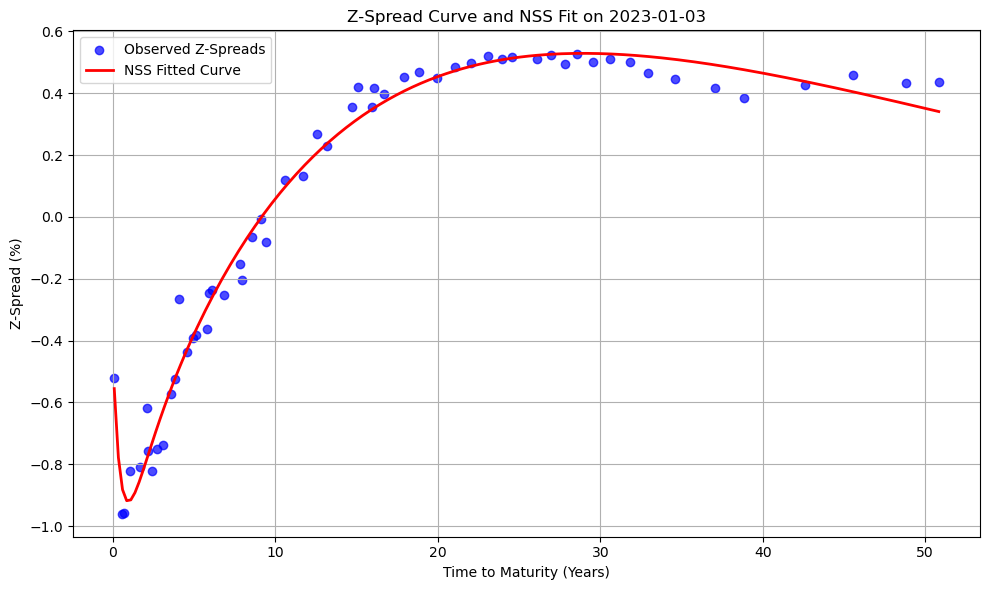

In [32]:
import matplotlib.pyplot as plt
import numpy as np

plot_date = pd.Timestamp("2023-01-03")

if plot_date in nss_params_df.index and pd.notna(nss_params_df.loc[plot_date]).all():
    params = nss_params_df.loc[plot_date]
    
    t_arr, z_arr = get_nss_data_for_date(plot_date, zspread_df, maturity_dict)
    
    valid = (z_arr > -2) & (z_arr < 4)
    t_arr = t_arr[valid]
    z_arr = z_arr[valid]

    t_fit = np.linspace(min(t_arr), max(t_arr), 200)
    z_fit = nss_func(t_fit, *params)

    plt.figure(figsize=(10, 6))
    plt.scatter(t_arr, z_arr, color='blue', label='Observed Z-Spreads', alpha=0.7)
    plt.plot(t_fit, z_fit, color='red', linewidth=2, label='NSS Fitted Curve')
    plt.title(f"Z-Spread Curve and NSS Fit on {plot_date.date()}")
    plt.xlabel("Time to Maturity (Years)")
    plt.ylabel("Z-Spread (%)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
else:
    print(f"NSS parameters for {plot_date.date()} are not available or invalid.")

# Part 4 Strategy

## 4.1 Analysis

### 4.1.1 Z-spread heatmap

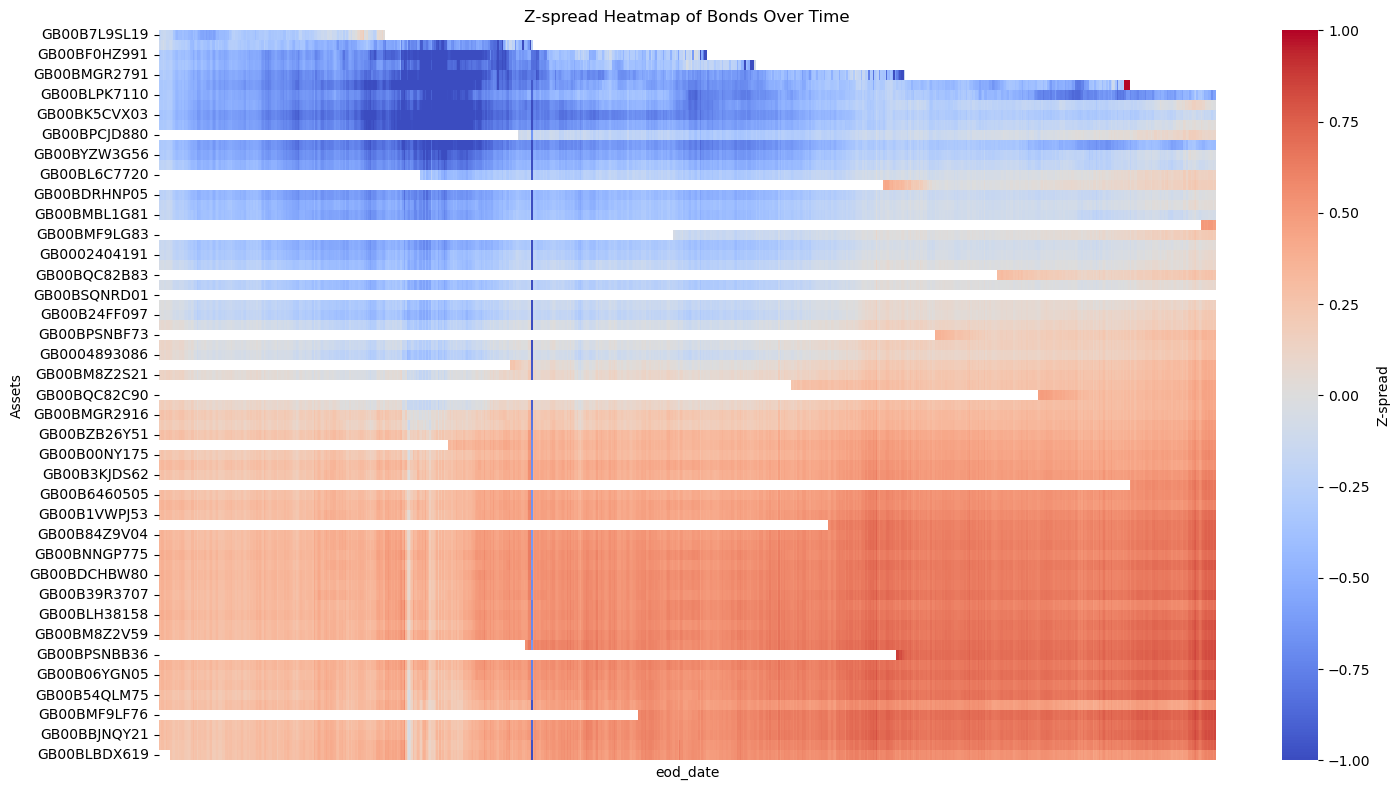

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 8))
data = zspread_df.T.astype(float)

ax = sns.heatmap(
    data,
    cmap="coolwarm",
    center=0,
    vmin=-1, vmax=1, 
    cbar_kws={'label': 'Z‑spread'}
)

ax.set_xticks([])

plt.title("Z‑spread Heatmap of Bonds Over Time")
plt.ylabel("Assets")
plt.tight_layout()
plt.show()

### 4.1.2 Price

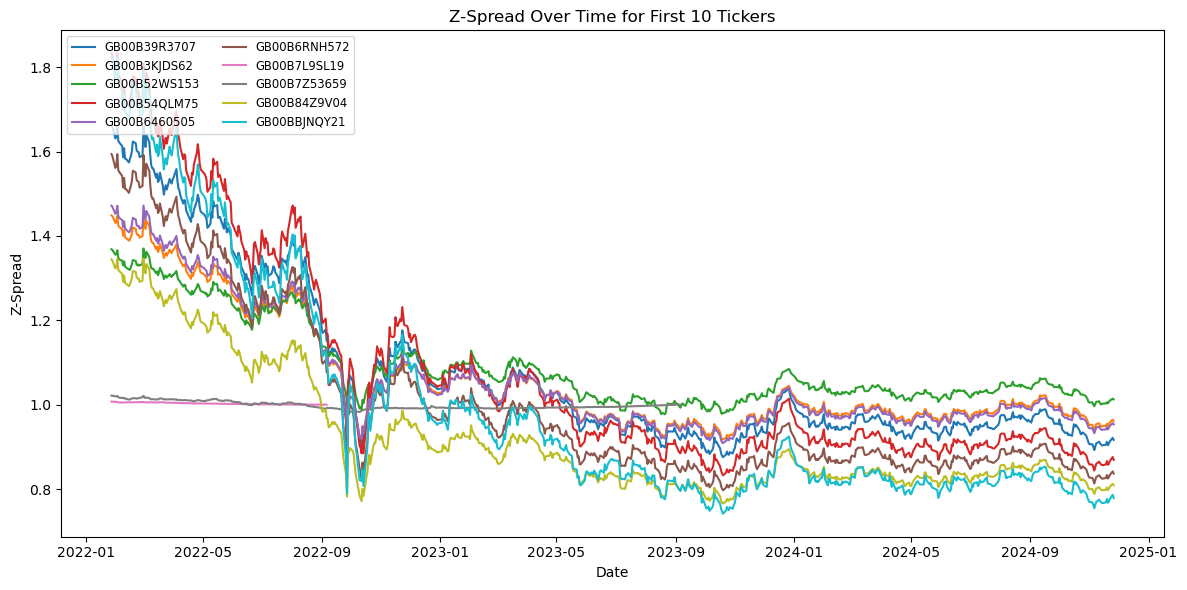

In [53]:
import matplotlib.pyplot as plt

cols = df3.columns[10:20]

plt.figure(figsize=(12, 6))
for col in cols:
    plt.plot(df3.index, df3[col], label=col)
plt.title("Z-Spread Over Time for First 10 Tickers")
plt.xlabel("Date")
plt.ylabel("Z-Spread")
plt.legend(loc="upper left", ncol=2, fontsize="small")
plt.tight_layout()
plt.show()

### 4.1.3 Z-spread

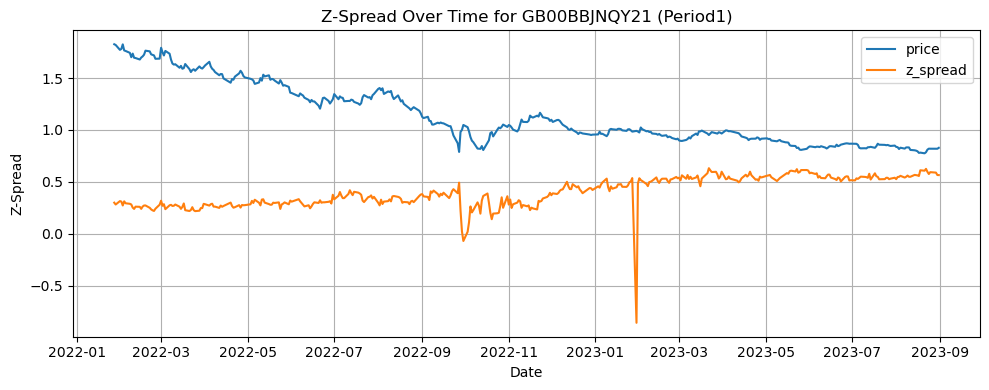

In [56]:
plt.figure(figsize=(10, 4))
#plt.plot(df3.index, df3['GB0030880693'], marker='o', linestyle='-')
plt.plot(df3.iloc[:400].index, df3['GB00BBJNQY21'].iloc[:400], marker='', linestyle='-', label='price')
plt.plot(df3.iloc[:400].index, zspread_df['GB00BBJNQY21'].iloc[:400], marker='', linestyle='-', label='z_spread')
plt.title(f"Z-Spread Over Time for {col} (Period1)")
plt.xlabel("Date")
plt.ylabel("Z-Spread")
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

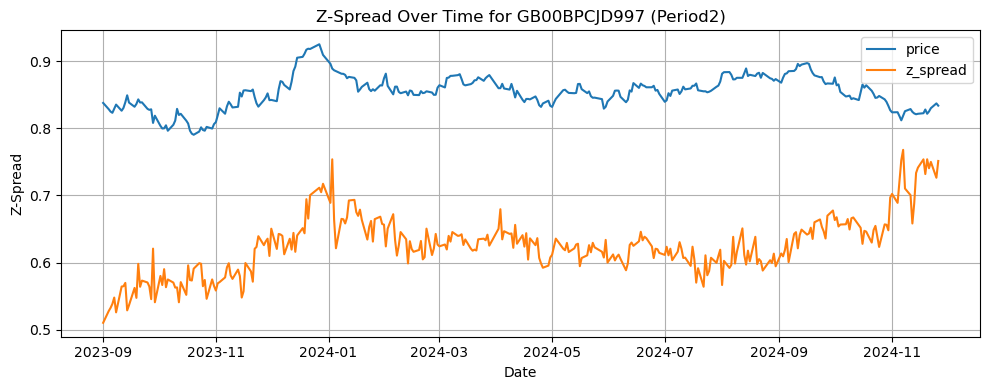

In [69]:
plt.figure(figsize=(10, 4))
#plt.plot(df3.index, df3['GB00BLPK7110'], marker='o', linestyle='-')
plt.plot(df3.iloc[400:].index, df3['GB00BN65R313'].iloc[400:], marker='', linestyle='-', label='price')
plt.plot(df3.iloc[400:].index, zspread_df['GB00BN65R313'].iloc[400:], marker='', linestyle='-', label='z_spread')
plt.title(f"Z-Spread Over Time for {col} (Period2)")
plt.xlabel("Date")
plt.ylabel("Z-Spread")
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

## 4.2 Strategy

### 4.2.1 Dynamic

               3M          6M          1Y
count  412.000000  349.000000  223.000000
mean    -0.005815   -0.011948   -0.007477
std      0.036342    0.044533    0.044594
min     -0.108317   -0.136680   -0.114164
25%     -0.025644   -0.031877   -0.045963
50%     -0.001768    0.003752   -0.005505
75%      0.009603    0.016469    0.029376
max      0.118180    0.092714    0.082102


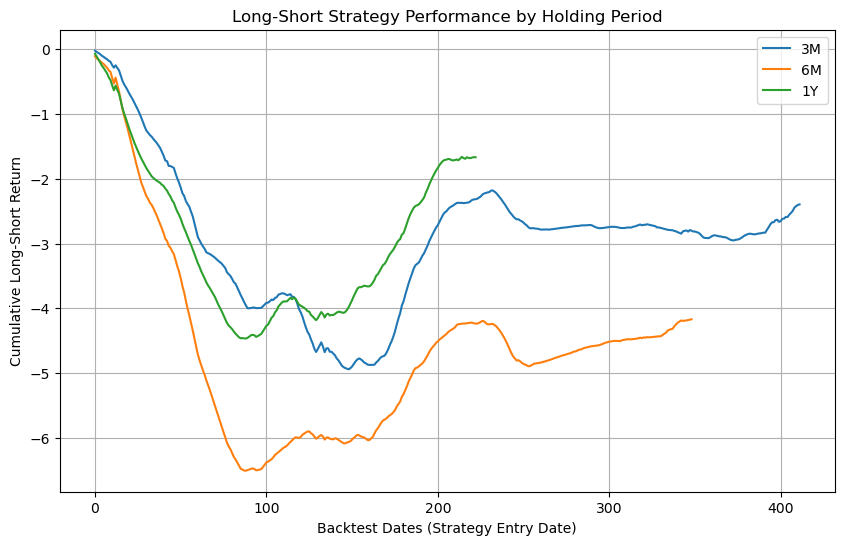

In [78]:
import numpy as np
import pandas as pd

horizons = {"3M": 63, "6M": 126, "1Y": 252}
lookback = 240  
z_threshold = 0.6  
strategy_results = {k: [] for k in horizons}
dates = zspread_df.index
n = len(dates)

for i, today in enumerate(dates):
    if i < lookback:
        continue
    #z_threshold = 0.8 if i < 250 else 0.6
    
    zs_today = zspread_df.loc[today]
    ps_today = df3.loc[today]
    
    #window = zspread_df.iloc[i:i+lookback] 
    window = zspread_df.iloc[i-lookback:i] 
    zs_mean = window.mean()
    zs_std  = window.std()

    upper = zs_mean + z_threshold * zs_std
    lower = zs_mean - z_threshold * zs_std
    

    valid = zs_today.notna() & ps_today.notna() & upper.notna() & lower.notna()
    if valid.sum() < 20:
        continue

    zs = zs_today[valid]
    ps = ps_today[valid]
    upper = upper[valid]
    lower = lower[valid]

    long_tickers = zs[zs >= upper].index
    short_tickers = zs[zs <= lower].index

    if len(long_tickers) == 0 and len(short_tickers) == 0:
        continue

    for label, offset in horizons.items():
        if i + offset >= n:
            continue

        future = dates[i + offset]
        ps_future = df3.loc[future, valid.index]
        valid_fwd = ps_future.notna()
        if valid_fwd.sum() < 5:
            continue

        ps0 = ps[valid_fwd]
        ps1 = ps_future[valid_fwd]
        ret = (ps1 - ps0) / ps0

        l = [t for t in long_tickers if t in ret.index]
        s = [t for t in short_tickers if t in ret.index]

        long_ret = ret[l].mean() if l else 0
        short_ret = ret[s].mean() if s else 0

        strategy_results[label].append(long_ret - short_ret)


strategy_df = pd.DataFrame({k: pd.Series(v) for k, v in strategy_results.items()})
print(strategy_df.describe())
plt.figure(figsize=(10,6))
strategy_df["3M"].cumsum().plot(label="3M")
strategy_df["6M"].cumsum().plot(label="6M")
strategy_df["1Y"].cumsum().plot(label="1Y")
plt.xlabel("Backtest Dates (Strategy Entry Date)")
plt.ylabel("Cumulative Long-Short Return")
plt.title("Long-Short Strategy Performance by Holding Period")
plt.legend()
plt.grid(True)
plt.show()

### 4.2.2 Cross Sectional

               3M          6M          1Y
count  652.000000  589.000000  463.000000
mean    -0.046990   -0.087067   -0.145053
std      0.076977    0.101872    0.116636
min     -0.302688   -0.382331   -0.399636
25%     -0.093867   -0.163614   -0.262363
50%     -0.045976   -0.072678   -0.129100
75%      0.000765   -0.008926   -0.051654
max      0.245812    0.257742    0.076962


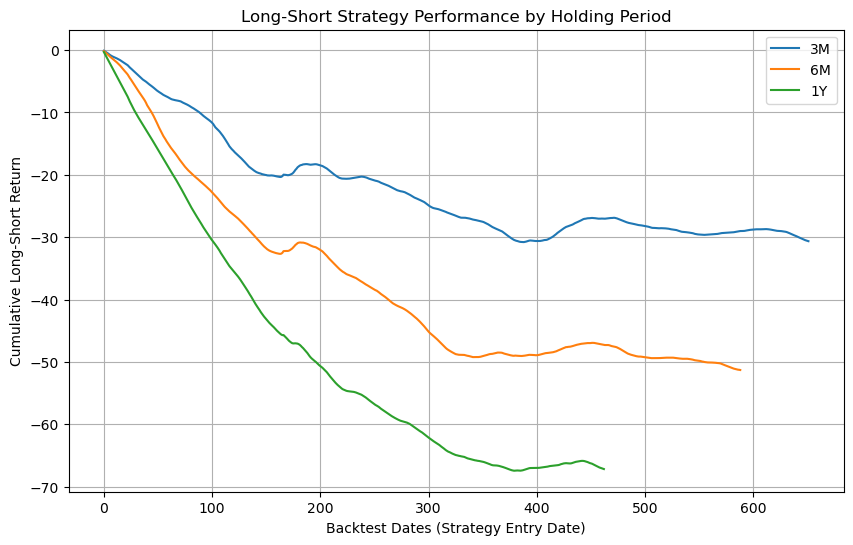

In [80]:
strategy_results = {
    "3M": [],
    "6M": [],
    "1Y": []
}

horizons = {
    "3M": 63,
    "6M": 126,
    "1Y": 252
}

percentile_threshold = 10  

dates = zspread_df.index

for i, current_date in enumerate(dates):
    for label, offset in horizons.items():
        if i + offset >= len(dates):
            continue

        future_date = dates[i + offset]
        px_now = df3.loc[current_date] if current_date in df3.index else None
        px_future = df3.loc[future_date] if future_date in df3.index else None
        z_now = zspread_df.loc[current_date]

        if px_now is None or px_future is None:
            continue

        valid_mask = (~z_now.isna()) & (~px_now.isna()) & (~px_future.isna())
        if valid_mask.sum() < 10:
            continue

        z_filtered = z_now[valid_mask]
        px_now = px_now[valid_mask]
        px_future = px_future[valid_mask]
        ret = (px_future - px_now) / px_now

        high_cut = np.percentile(z_filtered, 100 - percentile_threshold)
        low_cut = np.percentile(z_filtered, percentile_threshold)

        high_grp = z_filtered[z_filtered >= high_cut].index
        low_grp = z_filtered[z_filtered <= low_cut].index

        long_ret = ret[high_grp].mean() if len(high_grp) > 0 else 0
        short_ret = ret[low_grp].mean() if len(low_grp) > 0 else 0
        long_short = long_ret - short_ret

        strategy_results[label].append(long_short)

strategy_df = pd.DataFrame({
    k: pd.Series(v) for k, v in strategy_results.items()
})

print(strategy_df.describe())
plt.figure(figsize=(10,6))
strategy_df["3M"].cumsum().plot(label="3M")
strategy_df["6M"].cumsum().plot(label="6M")
strategy_df["1Y"].cumsum().plot(label="1Y")
plt.xlabel("Backtest Dates (Strategy Entry Date)")
plt.ylabel("Cumulative Long-Short Return")
plt.title("Long-Short Strategy Performance by Holding Period")
plt.legend()
plt.grid(True)
plt.show()

### 4.2.3 Theoretically feasible strategy

In [75]:
horizons = {"3M": 63, "6M": 126, "1Y": 252}
percentile_threshold = 10    
lookback = 240               
z_threshold = 0.6         

strategy_results = {k: [] for k in horizons}
all_dates = zspread_df.index
n_total = len(all_dates)


for i, current_date in enumerate(all_dates):

    if i < 380:
        z_now = zspread_df.loc[current_date]
        px_now = df3.loc[current_date] if current_date in df3.index else None

        for label, offset in horizons.items():
            if i + offset >= n_total:
                continue
            future_date = all_dates[i + offset]
            px_future = df3.loc[future_date] if future_date in df3.index else None
            if px_now is None or px_future is None:
                continue

            valid_mask = (~z_now.isna()) & (~px_now.isna()) & (~px_future.isna())
            if valid_mask.sum() < 10:
                continue

            z_filtered = z_now[valid_mask]
            px_now = px_now[valid_mask]
            px_future = px_future[valid_mask]
            ret = (px_future - px_now) / px_now

            high_cut = np.percentile(z_filtered, 100 - percentile_threshold)
            low_cut = np.percentile(z_filtered, percentile_threshold)

            high_grp = z_filtered[z_filtered >= high_cut].index
            low_grp = z_filtered[z_filtered <= low_cut].index

            long_ret = ret[high_grp].mean() if len(high_grp) > 0 else 0
            short_ret = ret[low_grp].mean() if len(low_grp) > 0 else 0
            long_short = short_ret - long_ret

            strategy_results[label].append(long_short)


    else:
        if i - lookback < 0:
            continue

        today = current_date
        zs_today = zspread_df.loc[today]
        ps_today = df3.loc[today]

        window = zspread_df.iloc[i - lookback:i]
        zs_mean = window.mean()
        zs_std = window.std()

        upper = zs_mean + z_threshold * zs_std
        lower = zs_mean - z_threshold * zs_std

        valid = zs_today.notna() & ps_today.notna() & upper.notna() & lower.notna()
        if valid.sum() < 20:
            continue

        zs = zs_today[valid]
        ps = ps_today[valid]
        upper = upper[valid]
        lower = lower[valid]

        long_tickers = zs[zs >= upper].index
        short_tickers = zs[zs <= lower].index

        if len(long_tickers) == 0 and len(short_tickers) == 0:
            continue

        for label, offset in horizons.items():
            if i + offset >= n_total:
                continue

            future = all_dates[i + offset]
            ps_future = df3.loc[future, valid.index]
            valid_fwd = ps_future.notna()
            if valid_fwd.sum() < 5:
                continue

            ps0 = ps[valid_fwd]
            ps1 = ps_future[valid_fwd]
            ret = (ps1 - ps0) / ps0

            l = [t for t in long_tickers if t in ret.index]
            s = [t for t in short_tickers if t in ret.index]

            long_ret = ret[l].mean() if l else 0
            short_ret = ret[s].mean() if s else 0

            strategy_results[label].append(long_ret - short_ret)


strategy_df = pd.DataFrame({k: pd.Series(v) for k, v in strategy_results.items()})
print(strategy_df.describe())

               3M          6M          1Y
count  652.000000  589.000000  463.000000
mean     0.050214    0.086342    0.150892
std      0.070216    0.100390    0.108530
min     -0.245812   -0.257742   -0.019600
25%      0.001350    0.007294    0.051819
50%      0.039116    0.062248    0.129100
75%      0.094560    0.163614    0.262363
max      0.302688    0.382331    0.399636


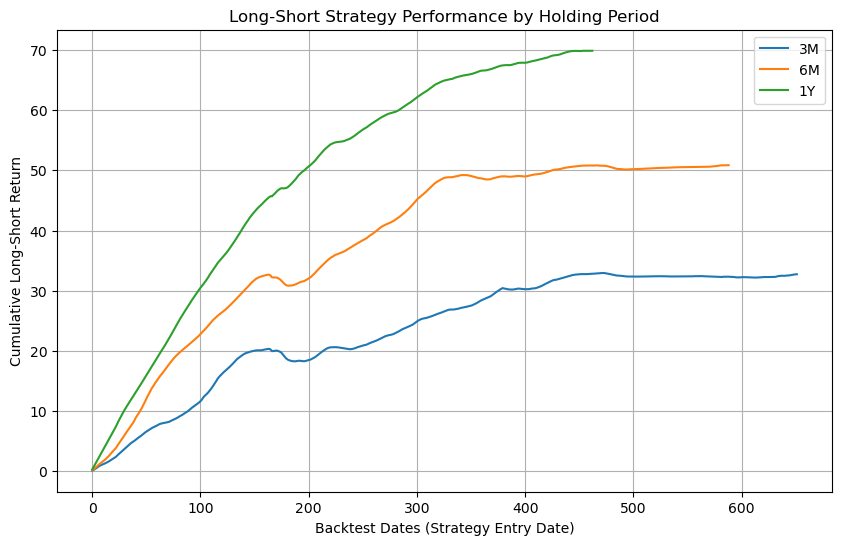

In [76]:
plt.figure(figsize=(10,6))
strategy_df["3M"].cumsum().plot(label="3M")
strategy_df["6M"].cumsum().plot(label="6M")
strategy_df["1Y"].cumsum().plot(label="1Y")
plt.xlabel("Backtest Dates (Strategy Entry Date)")
plt.ylabel("Cumulative Long-Short Return")
plt.title("Long-Short Strategy Performance by Holding Period")
plt.legend()
plt.grid(True)
plt.show()

In [77]:
strategy_metrics = {}

for col in strategy_df.columns:
    returns = strategy_df[col].dropna()

    if len(returns) < 2:
        continue

    mean_ret = returns.mean()
    std_ret = returns.std()
    sharpe = (mean_ret / std_ret) * np.sqrt(252) if std_ret != 0 else np.nan

    cumulative = (1 + returns).cumprod()

    peak = cumulative.cummax()
    drawdown = (cumulative - peak) / peak
    max_drawdown = -drawdown.min()

    strategy_metrics[col] = {
        "Mean": mean_ret,
        "Std": std_ret,
        "Sharpe": sharpe,
        "Max Drawdown": max_drawdown,
    }

metrics_df = pd.DataFrame(strategy_metrics).T
print(metrics_df)

        Mean       Std     Sharpe  Max Drawdown
3M  0.050214  0.070216  11.352452      0.896682
6M  0.086342  0.100390  13.653103      0.862909
1Y  0.150892  0.108530  22.070697      0.029040
